In [1]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [3]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [4]:

# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx
    return W

In [5]:
def precalculate_a(X: np.ndarray) -> np.ndarray:
    
    n,d = X.shape
    a = np.zeros((d,))
    for k in range (d):
        for i in range (n):
            a[k] = a[k] + (X[i][k]**2)
    return a




In [6]:

# TODO: coordinate descent of lasso, note lmda stands for lambda

def soft_thresholding(kc, lmda, ka):
    if kc < -lmda:
        return (kc + lmda) / ka
    elif kc > lmda:
        return (kc - lmda) / ka
    else:
        return 0


def lasso(X, y, lmda=10.0, epsilon=1.0e-2, max_iter=100, draw_curve=False):
    weight, b = Initialw(X, y)
    i = 0
    prev_weight = np.zeros(X.shape[1])
    a = precalculate_a(X)
    loss_hist = []
    while True:
        for j in range(X.shape[1]):
            # update weight j
            cj = np.dot(X[:, j].T, y - (b + np.dot(X, weight) - weight[j] * X[:, j]))
            weight[j] = soft_thresholding(cj, lmda, a[j])
        
        # update intercept
        b = np.mean(y - np.dot(X, weight))
        
        # calculate loss
        loss = np.sum((b + np.dot(X, weight) - y)**2) / 2 + lmda*np.sum(np.abs(weight))
        loss_hist.append(loss)
        
        # check stopping criteria
        if np.max(np.abs(weight - prev_weight)) < epsilon or i >= max_iter:
            break
            
        prev_weight = weight.copy()
        i += 1
        
        
    return weight, b, i, loss_hist


In [7]:

X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
# print(X)
# print(y)
print(w_true.shape)
print(w_true)

(75,)
[ 10. -10. -10.  10.  10.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]


[ 9.79800275e+00 -9.68563053e+00 -9.69063070e+00  9.82989921e+00
  9.94349829e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.18879339e-02
  1.52358400e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.40473500e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.26609958e-02  0.00000000e+00
 -7.13624975e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.90777951e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

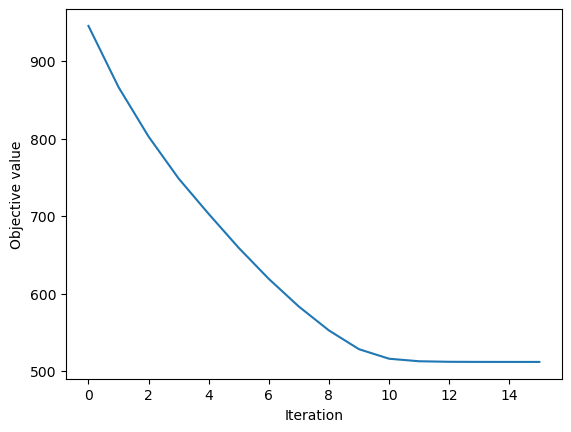

(75,)


In [8]:
# Problem 3(a): run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso, i, loss_hist = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = True)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)
print(w0_lasso)
#plt.plot(range(len(loss_hist)),loss_hist)
print(loss_hist[-1])
plt.plot(loss_hist)
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.show()
print(w_lasso.shape)

In [9]:
# Problem 3(b):
# TODO: evaluation function of lasso model
def root_mean_square_error(pred, y):
    #TODO
    rmse = np.sqrt((np.sum((y - pred)**2))*(1/len(y)))
    return rmse

def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    # Find indices of nonzero entries in w and w0
    nonzero_w = np.nonzero(w)[0]
    nonzero_w_true = np.nonzero(w_true)[0]
    
    common_samples = set(nonzero_w).intersection(set(nonzero_w_true))
    precision_w = len(common_samples) / len(nonzero_w)
    recall_w = len(common_samples) / len(nonzero_w_true)
    
    sparsity_w = len(nonzero_w)
    
    pred = X @ w + w0

    rmse = root_mean_square_error(pred,y)
    
    return (rmse, sparsity_w, precision_w, recall_w)

In [10]:

# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
rmse, sparsity, precision, recall = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print("RMSE: ",rmse)
print("Sparsity: ", sparsity)
print("Precision: ", precision)
print("Recall: ", recall)

RMSE:  0.8264628606247799
Sparsity:  13
Precision:  0.38461538461538464
Recall:  1.0


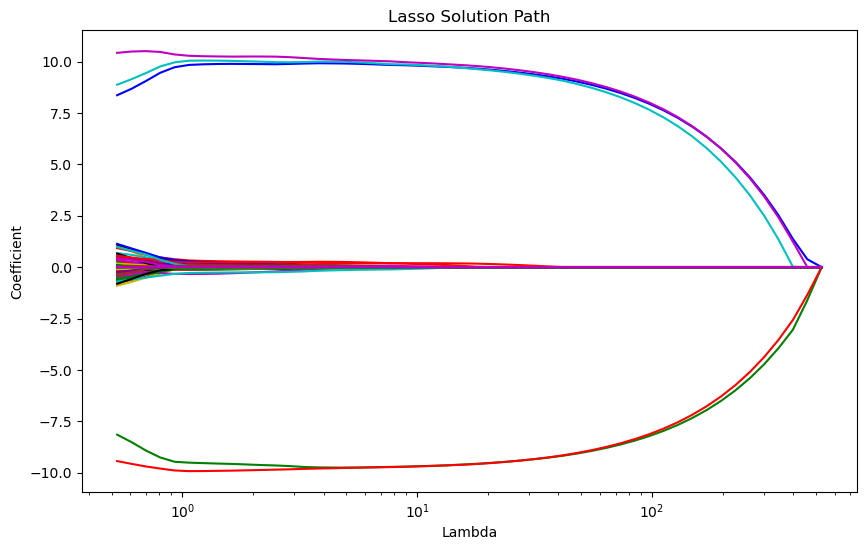

In [11]:
# Problem 3(c), first part
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
lmda_max = np.max(np.abs((np.dot(X.T,(y - np.mean(y))))))
lmda_min = 0
Lmda = np.arange(lmda_min, lmda_max, 50)
lambda_values = np.logspace(np.log10(lmda_max), np.log10(0.001*lmda_max), num=50)
def LassoPath(X, y):
    W = np.zeros((X.shape[1], len(lambda_values)))
    #W = np.zeros((X.shape[1], len(Lmda)))
    W0 = np.zeros((X.shape[1], 1))
    #W,W0 = Initialw(X,y)
    for i, lmda in enumerate(lambda_values):
        w, b, _, _ = lasso(X, y, lmda=lmda)
        W[:, i] = w
        W0[i, :] = b

    # Plot the solution path for each entry of theta
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    for i in range(X.shape[1]):
        plt.plot(lambda_values, W[i], color=colors[i%len(colors)], label=f'Feature {i+1}')
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('Coefficient')
    plt.title('Lasso Solution Path')
    #plt.ylim(-1,1)
    #plt.legend()
    plt.show()
 

    return (W, W0, Lmda)
W, W0, lmdas = LassoPath(X,y)


In [12]:
# Problem 3(c), third part:
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)

In [13]:
# Problem 3(d):
# TODO: try another different choices of (n,m) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=150, k=5, sigma=1.0)

In [11]:
# Problem 3(e): predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=int)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)



In [12]:
# Set the file paths
Xfile = "star_data.mtx"
yfile = "star_labels.txt"
nfile = "star_features.txt"

# Set the sizes for the training, validation, and test sets
train_size = 30000
valid_size = 5000

# Parse the data
X_train, y_train, X_valid, y_valid, X_test, y_test, feature_names = DataParser(Xfile, yfile, nfile, train_size, valid_size)

In [13]:
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_valid shape: ",X_valid.shape)
print("y_valid shape: ",y_valid.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (30000, 2500)
y_train shape:  (30000,)
X_valid shape:  (5000, 2500)
y_valid shape:  (5000,)
X_test shape:  (10000, 2500)
y_test shape:  (10000,)


In [17]:
X_t = sparse.csc_matrix(X_train)
print(X_t.shape)

def precalculate_a(X: np.ndarray) -> np.ndarray:
    n,d = X.shape
    a = np.zeros((d,))
    for k in range (d):
        for i in range (n):
            a[k] = a[k] + (X[i][k]**2)
    return a

a1 = sum(X_t.multiply(X_t))
print(a1.shape)

(30000, 2500)
(1, 2500)


In [18]:
# Performing lasso on a real dataset with sparse matrix libraries to save memory 

def soft_thresholding(kc, lmda, ka):
    ka_recip = sparse.linalg.inv(ka)
    if kc < -lmda:
        s_t = (kc + lmda)*ka_recip
        return s_t
    elif kc > lmda:
        s_t = (kc - lmda)*ka_recip
        return s_t
    else:
        return 0
    
    
def get_sparse_w0(w0,n):
    scalar = w0
    l = np.zeros((n,1))
    l = l+scalar
    k = sparse.csc_matrix(l, shape = (n,1))
    return k

def lasso_coordinate_descent(X, y, lmda=10.0, epsilon=1.0e-2, max_iter=100, draw_curve=False):
    w,w0 = Initialw(X,y)
    n, m = X.shape
    prev_weight = np.zeros(m)
    X = sparse.csc_matrix(X)
    y = sparse.csc_matrix(y)
    
    w.reshape(-1,1)
    i = 0
    a =  sum(X.multiply(X)).T
    loss_hist = []
    while True:
            for j in range(m):
                
                Xw = X.dot(w)
                
                Xw = Xw.reshape(-1,1)
                Xj = X.getcol(j)
                w0_sparse = get_sparse_w0(w0,n)
            
                y = y.reshape(-1,1)
                cj_two = y - (w0_sparse + Xw - Xj.multiply(w[j]))
                cj_one = Xj.T
                cj = cj_one.dot(cj_two)
                
                w[j] = soft_thresholding(cj, lmda, a.getrow(j))   #numpy array
                
            
            
            Xw1 = X.dot(w)
            Xw1 = Xw1.reshape(-1,1)
            w0 = sparse.csc_matrix.mean(y - Xw1)
            w0_sparse1 = get_sparse_w0(w0,n)
            #calculate loss
            
            temp = sum(((w0_sparse1 + Xw1 - y).T).dot(w0_sparse1 + Xw1 - y))
            
            
            loss = temp/2 + lmda*np.sum(np.abs(w))
            
            loss_hist.append(loss)
            
            #stopping criteria
            if np.max(np.abs(w - prev_weight)) < epsilon or i >= max_iter:
                print("last iter num: ",i)
                break
                

            prev_weight = w.copy()
            i += 1
            print("iteration number: ",i)
        
        
    return w, w0, i, loss_hist


In [38]:
lmdamax_two = y_train - np.mean(y_train)
lmdamax_one = X_train.T
lmda_max_dot = lmdamax_one.dot(lmdamax_two)
lmdamax_abs = np.abs(lmda_max_dot)
lmda_max1 = np.max(lmdamax_abs)
lmda_min1 = 0.08*lmda_max1
Lmda = np.arange(lmda_min1, lmda_max1,20)
lambda_values1 = np.logspace(np.log10(lmda_max1), np.log10(0.001*lmda_max1), num=20)
#lmda_max = np.max(np.abs(np.dot(X_train.T,(y_train - np.mean(y_train)))))
print(lambda_values1)

[39.57825401 27.51451708 19.12789406 13.29757416  9.24437776  6.42662482
  4.46774328  3.10594294  2.15922916  1.50108056  1.04354039  0.72546176
  0.50433579  0.35061061  0.24374197  0.16944766  0.11779879  0.08189287
  0.05693134  0.03957825]


iteration number:  1
iteration number:  2
iteration number:  3
iteration number:  4
iteration number:  5
iteration number:  6
last iter num:  6
iteration number:  1
iteration number:  2
iteration number:  3
iteration number:  4
iteration number:  5
iteration number:  6
iteration number:  7
iteration number:  8
iteration number:  9
iteration number:  10
last iter num:  10
iteration number:  1
iteration number:  2
iteration number:  3
iteration number:  4
iteration number:  5
iteration number:  6
iteration number:  7
iteration number:  8
iteration number:  9
iteration number:  10
iteration number:  11
iteration number:  12
iteration number:  13
iteration number:  14
iteration number:  15
iteration number:  16
iteration number:  17
iteration number:  18
iteration number:  19
iteration number:  20
iteration number:  21
iteration number:  22
iteration number:  23
iteration number:  24
last iter num:  24
iteration number:  1
iteration number:  2
iteration number:  3
iteration number:  4
iter

iteration number:  100
last iter num:  100
iteration number:  1
iteration number:  2
iteration number:  3
iteration number:  4
iteration number:  5
iteration number:  6
iteration number:  7
iteration number:  8
iteration number:  9
iteration number:  10
iteration number:  11
iteration number:  12
iteration number:  13
iteration number:  14
iteration number:  15
iteration number:  16
iteration number:  17
iteration number:  18
iteration number:  19
iteration number:  20
iteration number:  21
iteration number:  22
iteration number:  23
iteration number:  24
iteration number:  25
iteration number:  26
iteration number:  27
iteration number:  28
iteration number:  29
iteration number:  30
iteration number:  31
iteration number:  32
iteration number:  33
iteration number:  34
iteration number:  35
iteration number:  36
iteration number:  37
iteration number:  38
iteration number:  39
iteration number:  40
iteration number:  41
iteration number:  42
iteration number:  43
iteration number:  4

iteration number:  71
iteration number:  72
iteration number:  73
iteration number:  74
iteration number:  75
iteration number:  76
iteration number:  77
iteration number:  78
iteration number:  79
iteration number:  80
iteration number:  81
iteration number:  82
iteration number:  83
iteration number:  84
iteration number:  85
iteration number:  86
iteration number:  87
iteration number:  88
iteration number:  89
iteration number:  90
iteration number:  91
iteration number:  92
iteration number:  93
iteration number:  94
iteration number:  95
iteration number:  96
iteration number:  97
iteration number:  98
iteration number:  99
iteration number:  100
last iter num:  100
iteration number:  1
iteration number:  2
iteration number:  3
iteration number:  4
iteration number:  5
iteration number:  6
iteration number:  7
iteration number:  8
iteration number:  9
iteration number:  10
iteration number:  11
iteration number:  12
iteration number:  13
iteration number:  14
iteration number:  1

iteration number:  42
iteration number:  43
iteration number:  44
iteration number:  45
iteration number:  46
iteration number:  47
iteration number:  48
iteration number:  49
iteration number:  50
iteration number:  51
iteration number:  52
iteration number:  53
iteration number:  54
iteration number:  55
iteration number:  56
iteration number:  57
iteration number:  58
iteration number:  59
iteration number:  60
iteration number:  61
iteration number:  62
iteration number:  63
iteration number:  64
iteration number:  65
iteration number:  66
iteration number:  67
iteration number:  68
iteration number:  69
iteration number:  70
iteration number:  71
iteration number:  72
iteration number:  73
iteration number:  74
iteration number:  75
iteration number:  76
iteration number:  77
iteration number:  78
iteration number:  79
iteration number:  80
iteration number:  81
iteration number:  82
iteration number:  83
iteration number:  84
iteration number:  85
iteration number:  86
iteration 

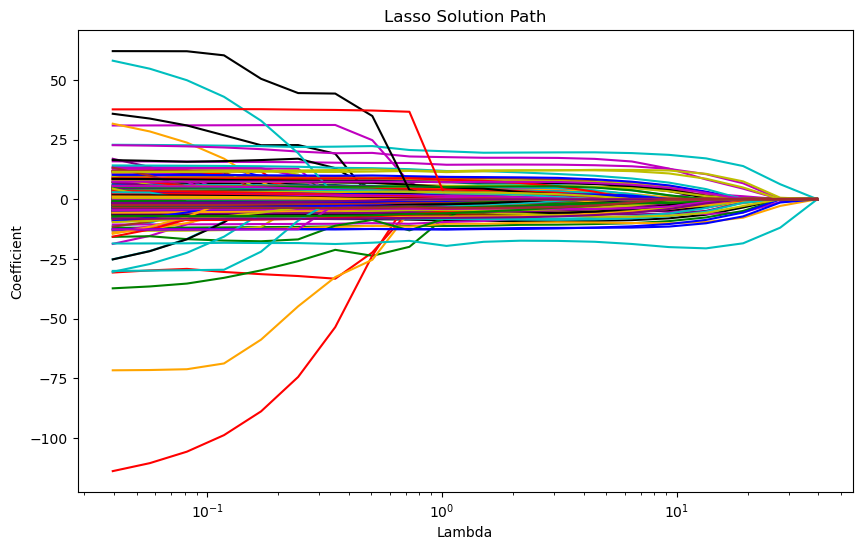

In [21]:
def Lasso_soln_path(X_train, y_train):
    #########TODO##########
    #lambda_values, Lmda = lambda_values_der(X_train,y_train)
    W_train = np.zeros((X_train.shape[1], len(lambda_values1)))
    W0_train = np.zeros((20, 1))
    for i, lmda in enumerate(lambda_values1):
        w, b, _, _ = lasso_coordinate_descent(X_train, y_train, lmda=lmda, epsilon=1.0e-2, max_iter=100, draw_curve=False)
        W_train[:,i] = w
        W0[i,:] = b
        
        # Plot the solution path for each entry of theta
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    for i in range(X_train.shape[1]):
        plt.plot(lambda_values1, W_train[i], color=colors[i%len(colors)], label=f'Feature {i+1}')
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('Coefficient')
    plt.title('Lasso Solution Path')
    plt.show()

    return (W_train, W0_train)
W, W0 = Lasso_soln_path(X_train,y_train)    

In [22]:
np.save('W.npy',W)
np.save('W0.npy',W0)

In [16]:
W = np.load('W.npy')
W0 = np.load('W0.npy')

In [21]:
W[:,0].shape
X_train.shape

(30000, 2500)

In [39]:
# Problem 3(e): predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    rmse_train = []
    for i in range(20):
        model = (X_train@ W[:,i])+ W0[i]
        rmse = root_mean_square_error(model,y_train)
        rmse_train.append(rmse)
    
    rmse_train = np.array(rmse_train)
    best = np.argmin(rmse_train)
    model_val = X_valid @ W[:,best]+ W0[best]
    rmse_val = root_mean_square_error(model_val,y_valid)
    w_lasso, w0_lasso, lmda_best = W[:,best], W0[best], lambda_values1[best]
    
    
    return (w_lasso, w0_lasso, lmda_best, rmse_val)

In [41]:
#Getting the best lambda
w_lasso, w0_lasso, lmda_best, rmse_val = Validation(X_train, y_train, X_valid, y_valid)

In [42]:
print('Best rmse:',rmse_val)

Best rmse: 3.862197793292481


In [43]:
lmda_best

1.0435403901526417